### Adapt inverse kinematics to ground locomotion data

This notebook contains the process to compute the inverse kinematics from the 3D pose measured in the flytracker setup. 

In [2]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import pandas as pd
import glob
import pickle
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

import matplotlib
matplotlib.pyplot.set_loglevel (level = 'warning')

from nmf_ik.utils import dict_to_nparray_pose, save_file, interpolate_signal, calculate_nmf_size
from nmf_ik.data import BOUNDS, NMF_SIZE, NMF_TEMPLATE, INITIAL_ANGLES
from nmf_ik.leg_inverse_kinematics import LegInverseKinematics
from nmf_ik.kinematic_chain import KinematicChainYPR
from nmf_ik.visualization import plot_3d_points, animate_3d_points

import sys

#DATA_PATH = Path("/Users/stimpfli/Desktop/sleap_flytracker/labeled_slp/nice_forward_loc1/output_clean")
DATA_PATH = Path("/Users/stimpfli/Desktop/sleap_flytracker/labeled_slp/revision_new_step_PR_bestdata_fly001_trial001subset_video_4_start5751_end6001/output_3D_joints_alfie")

aligned_pose_path = DATA_PATH / "df3dpp_output/aligned_df3dpp_int.pkl"
# Next two data come from the paper
aligned_pose_pp = pd.read_pickle(aligned_pose_path)

# joint_angles_pp = pd.read_pickle(
#     DATA_PATH / "joint_angles__210902_PR_Fly1.pkl"
# )

ANGLES = [
    "ThC_yaw",
    "ThC_pitch",
    "ThC_roll",
    "CTr_pitch",
    "CTr_roll",
    "FTi_pitch",
    "TiTa_pitch",
]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ImportError: cannot import name 'KinematicChainYPR' from 'nmf_ik.kinematic_chain' (/Users/stimpfli/Desktop/sequential-inverse-kinematics/nmf_ik/kinematic_chain.py)

## Dictionary conversion

In [103]:
# Aligned pose now in a nested dictionary format. -> dictionary[leg_name][key_point_name][raw_pos_aligned]
# My package is using numpy arrays, so we convert the pose dictionary into a compatible format

print(aligned_pose_pp.keys())

converted_aligned_pose = {}

for leg_name, leg_pose_data in aligned_pose_pp.items():
    if leg_name == 'meta':
        continue
#     print(leg_pose_data.keys())
    converted_aligned_pose[leg_name] = dict_to_nparray_pose(
        leg_pose_data, claw_is_end_effector=True
    )

dict_keys(['RF_leg', 'RM_leg', 'RH_leg', 'LF_leg', 'LM_leg', 'LH_leg', 'meta'])


In [104]:
print(converted_aligned_pose.keys())

converted_aligned_pose['RF_leg'].shape # timestep, key points, coordinates (x,y,z)

dict_keys(['RF_leg', 'RM_leg', 'RH_leg', 'LF_leg', 'LM_leg', 'LH_leg'])


(44, 5, 3)

In [105]:
# let's save the new dictionary
export_path_seqikpy_format_aligned_pos = DATA_PATH / 'seqikpy_format_aligned_pose/pose3d_aligned_int.pkl'
export_path_seqikpy_format_aligned_pos.parent.mkdir(parents=True, exist_ok=True)
save_file(export_path_seqikpy_format_aligned_pos, converted_aligned_pose)

In [106]:
# We will use these configs for the 3D plotting
KEY_POINTS_DICT = {
    "LH": (np.arange(25, 30), "solid"),
    "LM": (np.arange(20, 25), "solid"),
    "LF": (np.arange(15, 20), "solid"),
    "RH": (np.arange(10, 15), "solid"),
    "RM": (np.arange(5, 10), "solid"),
    "RF": (np.arange(0, 5), "solid"),
}

KEY_POINTS_DICT2 = {
    "LH": (np.arange(45, 54), ":"),
    "LM": (np.arange(36, 45), ":"),
    "LF": (np.arange(27, 36), ":"),
    "RH": (np.arange(18, 27), ":"),
    "RM": (np.arange(9, 18), ":"),
    "RF": (np.arange(0, 9), ":"),
}


In [107]:
# Plot the aligned pose
points_aligned_all = np.concatenate(
    (
        converted_aligned_pose["RF_leg"],
        converted_aligned_pose["RM_leg"],
        converted_aligned_pose["RH_leg"],
        converted_aligned_pose["LF_leg"],
        converted_aligned_pose["LM_leg"],
        converted_aligned_pose["LH_leg"],
    ),
    axis=1,
)

ax_limits = [-2.0, 2.0]

aligned_pose_export_path = DATA_PATH / 'aligned_pose'
aligned_pose_export_path.mkdir(parents=True, exist_ok=True)
for t in range(0, points_aligned_all.shape[0], 10):
    for azim, elev in [(0,0),(90,0),(0,90)]:

        fig = plt.figure(figsize=(12, 12))
        ax3d = fig.add_subplot(111, projection="3d")
        ax3d.view_init(azim=azim, elev=elev)

        ax3d.set_xlabel('x')
        ax3d.set_ylabel('y')
        ax3d.set_zlabel('z')
        
        plot_3d_points(
            ax3d,
            points_aligned_all,
            KEY_POINTS_DICT,
            label_prefix="Aligned pose ",
            t=t,
            fix_lim=True,
            export_path=aligned_pose_export_path/ f'azim_{azim}_elev_{elev}_{t}.png',
        )
        plt.close()

## Using sequential Inverse Kinematics
* Interpolate the data

In [108]:
converted_aligned_pose["RF_leg"].shape

(44, 5, 3)

In [109]:
# Interpolate the aligned pose:
intpd_pose = {}
for body_part, bp_array in converted_aligned_pose.items():
    # I don't know what the old time step is, so I  just guessed it.
    if "int" in aligned_pose_path.name:
        # already interpolated
        inpd_array = bp_array
    else:
        inpd_array = interpolate_signal(bp_array, 
                                        aligned_pose_pp["meta"]["timestep"], 0.001)
    print(inpd_array.shape)
    intpd_pose[body_part] = inpd_array
    
if "int" not in aligned_pose_path.name:
    aligned_pose_pp["meta"]["timestep"] = 5e-3

(44, 5, 3)
(44, 5, 3)
(44, 5, 3)
(44, 5, 3)
(44, 5, 3)
(44, 5, 3)


In [110]:
# Now we converted the aligned pose from nested dictionary to numpy arrays.
# Let's start using seq_ik

# Step 1: alignment - already done using DF3DPP so we can skip

"""
align = AlignPose(DATA_PATH, pts2align=PTS2ALIGN, nmf_template=NMF_TEMPLATE)
aligned_pos = align.align_pose(
    save_pose_file=True,
)
"""

# Step 2. calculation of joint angles
# We are defining a set of initial seeds for the IK optimization

INITIAL_ANGLES_LOCOMOTION = {
    "RF": {
        # Base ThC yaw pitch CTr pitch
        "stage_1": np.array([0.0, 0.45, -0.07, -2.14]),
        # Base ThC yaw pitch roll CTr pitch CTr roll
        "stage_2": np.array([0.0, 0.45, -0.07, -0.32, -2.14, 1.4]),
        # Base ThC yaw pitch roll CTr pitch CTr roll FTi pitch
        "stage_3": np.array([0.0, 0.45, -0.07, -0.32, -2.14, -1.25, 1.48, 0.0]),
        # Base ThC yaw pitch roll CTr pitch CTr roll FTi pitch TiTa pitch
        "stage_4": np.array([0.0, 0.45, -0.07, -0.32, -2.14, -1.25, 1.48, 0.0, 0.0]),
    },

    "LF": {
        "stage_1": np.array([0.0, -0.45, -0.07, -2.14]),
        "stage_2": np.array([0.0, -0.45, -0.07, 0.32, -2.14, 1.4]),
        "stage_3": np.array([0.0, -0.45, -0.07, 0.32, -2.14, 1.25, 1.48, 0.0]),
        "stage_4": np.array([0.0, -0.45, -0.07, 0.32, -2.14, 1.25, 1.48, 0.0, 0.0]),
    },

    "RM": {
        "stage_1": np.array([0.0, 0.45, 0.37, -2.14]),
        "stage_2": np.array([0.0, 0.45, 0.37, -0.32, -2.14, 1.4]),
        "stage_3": np.array([0.0, 0.45, 0.37, -0.32, -2.14, -1.25, 1.48, 0.0]),
        "stage_4": np.array([0.0, 0.45, 0.37, -0.32, -2.14, -1.25, 1.48, 0.0, 0.0]),
    },

    "LM": {
        "stage_1": np.array([0.0, -0.45, 0.37, -2.14]),
        "stage_2": np.array([0.0, -0.45, 0.37, 0.32, -2.14, 1.4]),
        "stage_3": np.array([0.0, -0.45, 0.37, 0.32, -2.14, 1.25, 1.48, 0.0]),
        "stage_4": np.array([0.0, -0.45, 0.37, 0.32, -2.14, 1.25, 1.48, 0.0, 0.0]),
    },

    "RH": {
        "stage_1": np.array([0.0, 0.45, 0.07, -2.14]),
        "stage_2": np.array([0.0, 0.45, 0.07, -0.32, -2.14, 1.4]),
        "stage_3": np.array([0.0, 0.45, 0.07, -0.32, -2.14, -1.25, 1.48, 0.0]),
        "stage_4": np.array([0.0, 0.45, 0.07, -0.32, -2.14, -1.25, 1.48, 0.0, 0.0]),
    },

    "LH": {
        "stage_1": np.array([0.0, -0.45, 0.07, -2.14]),
        "stage_2": np.array([0.0, -0.45, 0.07, 0.32, -2.14, 1.4]),
        "stage_3": np.array([0.0, -0.45, 0.07, 0.32, -2.14, 1.25, 1.48, 0.0]),
        "stage_4": np.array([0.0, -0.45, 0.07, 0.32, -2.14, 1.25, 1.48, 0.0, 0.0]),
    },

    "head": np.array([0, -0.17, 0]),  #  none, roll, pitch, yaw
}

# We define a template to create the kinematic chain
# The length of chain comes from the size calculated from the template

TEMPLATE_NMF_LOCOMOTION = {
    'RF_Coxa': np.array([0.35, -0.27, 0.400]),
    'RF_Femur': np.array([0.35, -0.27, -0.025]),
    'RF_Tibia': np.array([0.35, -0.27, -0.731]),
    'RF_Tarsus': np.array([0.35, -0.27, -1.249]),
    'RF_Claw': np.array([0.35, -0.27, -1.912]),
    'LF_Coxa': np.array([0.35, 0.27, 0.400]),
    'LF_Femur': np.array([0.35, 0.27, -0.025]),
    'LF_Tibia': np.array([0.35, 0.27, -0.731]),
    'LF_Tarsus': np.array([0.35, 0.27, -1.249]),
    'LF_Claw': np.array([0.35, 0.27, -1.912]),
    'RM_Coxa': np.array([0, -0.125, 0]),
    'RM_Femur': np.array([0, -0.125, -0.182]),
    'RM_Tibia': np.array([0, -0.125, -0.965]),
    'RM_Tarsus': np.array([0, -0.125, -1.633]),
    'RM_Claw': np.array([0, -0.125, -2.328]),
    'LM_Coxa': np.array([0, 0.125, 0]),
    'LM_Femur': np.array([0, 0.125, -0.182]),
    'LM_Tibia': np.array([0, 0.125, -0.965]),
    'LM_Tarsus': np.array([0, 0.125, -1.633]),
    'LM_Claw': np.array([0, 0.125, -2.328]),
    'RH_Coxa': np.array([-0.215, -0.087, -0.073]),
    'RH_Femur': np.array([-0.215, -0.087, -0.272]),
    'RH_Tibia': np.array([-0.215, -0.087, -1.108]),
    'RH_Tarsus': np.array([-0.215, -0.087, -1.793]),
    'RH_Claw': np.array([-0.215, -0.087, -2.588]),
    'LH_Coxa': np.array([-0.215, 0.087, -0.073]),
    'LH_Femur': np.array([-0.215, 0.087, -0.272]),
    'LH_Tibia': np.array([-0.215, 0.087, -1.108]),
    'LH_Tarsus': np.array([-0.215, 0.087, -1.793]),
    'LH_Claw': np.array([-0.215, 0.087, -2.588]),
}

# We determine the bounds for each joint DOF
BOUNDS_LOCOMOTION = {
 'RF_ThC_yaw': (np.deg2rad(-45), np.deg2rad(45)),
 'RF_ThC_pitch': (np.deg2rad(-10), np.deg2rad(90)),
 'RF_ThC_roll': (np.deg2rad(-135), np.deg2rad(10)),
 'RF_CTr_pitch': (np.deg2rad(-270), np.deg2rad(10)),
 'RF_FTi_pitch': (np.deg2rad(-10), np.deg2rad(180)),
 'RF_CTr_roll': (np.deg2rad(-180), np.deg2rad(90)),
 'RF_TiTa_pitch': (np.deg2rad(-180), np.deg2rad(10)),

 'RM_ThC_yaw': (np.deg2rad(-45), np.deg2rad(45)),
 'RM_ThC_pitch': (np.deg2rad(-10), np.deg2rad(90)),
 'RM_ThC_roll': (np.deg2rad(-180), np.deg2rad(10)),
 'RM_CTr_pitch': (np.deg2rad(-270), np.deg2rad(10)),
 'RM_FTi_pitch': (np.deg2rad(-10), np.deg2rad(180)),
 'RM_CTr_roll': (np.deg2rad(-90), np.deg2rad(90)),
 'RM_TiTa_pitch': (np.deg2rad(-180), np.deg2rad(10)),

 'RH_ThC_yaw': (np.deg2rad(-45), np.deg2rad(45)),
 'RH_ThC_pitch': (np.deg2rad(-10), np.deg2rad(90)),
 'RH_ThC_roll': (np.deg2rad(-180), np.deg2rad(10)),
 'RH_CTr_pitch': (np.deg2rad(-180), np.deg2rad(10)),
 'RH_FTi_pitch': (np.deg2rad(-10), np.deg2rad(180)),
 'RH_CTr_roll': (np.deg2rad(-90), np.deg2rad(90)),
 'RH_TiTa_pitch': (np.deg2rad(-180), np.deg2rad(10)),

 'LF_ThC_yaw': (np.deg2rad(-45), np.deg2rad(45)),
 'LF_ThC_pitch': (np.deg2rad(-10), np.deg2rad(90)),
 'LF_ThC_roll': (np.deg2rad(-10), np.deg2rad(90)),
 'LF_CTr_pitch': (np.deg2rad(-180), np.deg2rad(10)),
 'LF_FTi_pitch': (np.deg2rad(-10), np.deg2rad(180)),
 'LF_CTr_roll': (np.deg2rad(-90), np.deg2rad(180)),
 'LF_TiTa_pitch': (np.deg2rad(-180), np.deg2rad(10)),

 'LM_ThC_yaw': (np.deg2rad(-45), np.deg2rad(90)),
 'LM_ThC_pitch': (np.deg2rad(-10), np.deg2rad(90)),
 'LM_ThC_roll': (np.deg2rad(-10), np.deg2rad(180)),
 'LM_CTr_pitch': (np.deg2rad(-180), np.deg2rad(10)),
 'LM_FTi_pitch': (np.deg2rad(-10), np.deg2rad(180)),
 'LM_CTr_roll': (np.deg2rad(-90), np.deg2rad(90)),
 'LM_TiTa_pitch': (np.deg2rad(-180), np.deg2rad(10)),

 'LH_ThC_yaw': (np.deg2rad(-45), np.deg2rad(90)),
 'LH_ThC_pitch': (np.deg2rad(-10), np.deg2rad(90)),
 'LH_ThC_roll': (np.deg2rad(-10), np.deg2rad(180)),
 'LH_CTr_pitch': (np.deg2rad(-180), np.deg2rad(10)),
 'LH_FTi_pitch': (np.deg2rad(-10), np.deg2rad(180)),
 'LH_CTr_roll': (np.deg2rad(-90), np.deg2rad(90)),
 'LH_TiTa_pitch': (np.deg2rad(-180), np.deg2rad(10))
 }

for key, val in BOUNDS_LOCOMOTION.items():
    
    BOUNDS_LOCOMOTION[key] = (-np.pi, np.pi)

"""locomotion_bounds_path = Path("/Users/stimpfli/Desktop/sequential-inverse-kinematics/data_loc/bounds_from_loc.pkl")
# read from there
with open(locomotion_bounds_path, "rb") as f:
    BOUNDS_LOCOMOTION = pickle.load(f)

locomotion_init_path = Path("/Users/stimpfli/Desktop/sequential-inverse-kinematics/data_loc/init_angles_for_loc.pkl")
# read from there
with open(locomotion_init_path, "rb") as f:
    INITIAL_ANGLES_LOCOMOTION = pickle.load(f)

stage_joint_correspondence = {
    "stage_1": ["ThC_yaw", "ThC_pitch", "CTr_pitch"],
    "stage_2": ["ThC_yaw", "ThC_pitch", "ThC_roll", "CTr_pitch", "CTr_roll"],
    "stage_3": ["ThC_yaw", "ThC_pitch", "ThC_roll", "CTr_pitch", "CTr_roll", "FTi_pitch"],
    "stage_4": ["ThC_yaw", "ThC_pitch", "ThC_roll", "CTr_pitch", "CTr_roll", "FTi_pitch", "TiTa_pitch"],
}

joint_names = []
# plot the bounds and initial angles
fig = plt.figure(figsize=(12, 7))
for i, (joint, joint_bounds) in enumerate(BOUNDS_LOCOMOTION.items()):
    joint_names.append(joint)
    plt.scatter(i, joint_bounds[0], c="k", marker="^")
    plt.scatter(i, joint_bounds[1], c="k", marker="v")
    [leg_name, joint_name] = joint.split("_", 1)

    for stage in ["stage_1", "stage_2", "stage_3", "stage_4"]:
        if joint_name in stage_joint_correspondence[stage]:
            joint_idx = stage_joint_correspondence[stage].index(joint_name)
            plt.scatter(
                i,
                INITIAL_ANGLES_LOCOMOTION[leg_name][stage][joint_idx],
                c="C{}".format(i),
                marker="o",
            )
            if INITIAL_ANGLES_LOCOMOTION[leg_name][stage][joint_idx] < joint_bounds[0] or INITIAL_ANGLES_LOCOMOTION[leg_name][stage][joint_idx] > joint_bounds[1]:
                INITIAL_ANGLES_LOCOMOTION[leg_name][stage][joint_idx] = np.mean(joint_bounds)
                plt.scatter(
                i,
                INITIAL_ANGLES_LOCOMOTION[leg_name][stage][joint_idx],
                c="C{}".format(i),
                marker="x",
            )
plt.xticks(np.arange(len(joint_names)), joint_names, rotation=90)"""

# Calculate the size from the TEMPLATE_NMF_LOCOMOTION above
NMF_SIZE = calculate_nmf_size(TEMPLATE_NMF_LOCOMOTION)

In [111]:
# Double check to see how size differs from the template
nmf_size_from_aligned_pos = {}

for leg, leg_dict in aligned_pose_pp.items():
    if leg == 'meta':
        continue
    for segment in leg_dict:
        try:
#             a = leg_dict[segment]['mean_length']
            print('DF3DPP: ', leg, segment, leg_dict[segment]['mean_length'], 'TEMPLATE: ', NMF_SIZE[f'{leg[:2]}_{segment}'])
            nmf_size_from_aligned_pos[f'{leg[:2]}_{segment}'] =  leg_dict[segment]['mean_length']
        except:
            print('DF3DPP: ', leg, segment, leg_dict[segment]['total_length'], 'TEMPLATE: ', NMF_SIZE[f'{leg[:2]}'])



DF3DPP:  RF_leg Coxa 0.4239319752996349 TEMPLATE:  0.42500000000000004
DF3DPP:  RF_leg Femur 0.742818475966916 TEMPLATE:  0.706
DF3DPP:  RF_leg Tibia 0.5662009723252199 TEMPLATE:  0.5180000000000001
DF3DPP:  RF_leg Tarsus 0.6392929542386913 TEMPLATE:  0.6629999999999998
DF3DPP:  RF_leg Claw 2.372244377830462 TEMPLATE:  2.312
DF3DPP:  RM_leg Coxa 0.18232593053574392 TEMPLATE:  0.182
DF3DPP:  RM_leg Femur 0.7807688195944819 TEMPLATE:  0.7829999999999999
DF3DPP:  RM_leg Tibia 0.7937230414336239 TEMPLATE:  0.668
DF3DPP:  RM_leg Tarsus 0.659096935746946 TEMPLATE:  0.6949999999999998
DF3DPP:  RM_leg Claw 2.415914727310796 TEMPLATE:  2.328
DF3DPP:  RH_leg Coxa 0.19893290641823252 TEMPLATE:  0.199
DF3DPP:  RH_leg Femur 0.8354408121304563 TEMPLATE:  0.8360000000000001
DF3DPP:  RH_leg Tibia 0.7161798134837722 TEMPLATE:  0.6849999999999998
DF3DPP:  RH_leg Tarsus 0.7939030741330505 TEMPLATE:  0.7950000000000002
DF3DPP:  RH_leg Claw 2.5444566061655114 TEMPLATE:  2.515
DF3DPP:  LF_leg Coxa 0.4257009

## Run Sequential IK

In [112]:
# Let's run the seq IK..
kinematic_chain_class = KinematicChainYPR(
        bounds_dof=BOUNDS_LOCOMOTION,
        # Using the size comes from the alignment.
        nmf_size=nmf_size_from_aligned_pos,
        # nmf_size=NMF_SIZE,
    )

class_seq_ik = LegInverseKinematics(
    aligned_pos=intpd_pose,
    kinematic_chain_class=kinematic_chain_class,
    initial_angles=INITIAL_ANGLES_LOCOMOTION
)

# This will save two separate files:
# `leg_joint_angles.pkl` -> pickle file that containes the leg joint angles
# `forward_kinematics.pkl` -> 3D position of the legs construction from the calculated leg joint angles
# The latter is useful for debugging, visualization...
export_path = DATA_PATH / 'seq_ik_results'
export_path.mkdir(exist_ok=True)
leg_joint_angles, forward_kinematics = class_seq_ik.run_ik_and_fk(export_path=None) # where the results will be saved
leg_joint_angles["meta"] = aligned_pose_pp["meta"]
forward_kinematics["meta"] = aligned_pose_pp["meta"]
# save both as pkl files
with open(export_path / "leg_joint_angles.pkl", "wb") as f:
    pickle.dump(leg_joint_angles, f)
with open(export_path / "forward_kinematics.pkl", "wb") as f:
    pickle.dump(forward_kinematics, f)

Calculating joint angles and forward kinematics...


100%|██████████| 44/44 [00:01<00:00, 36.33it/s]


## 2D visualization

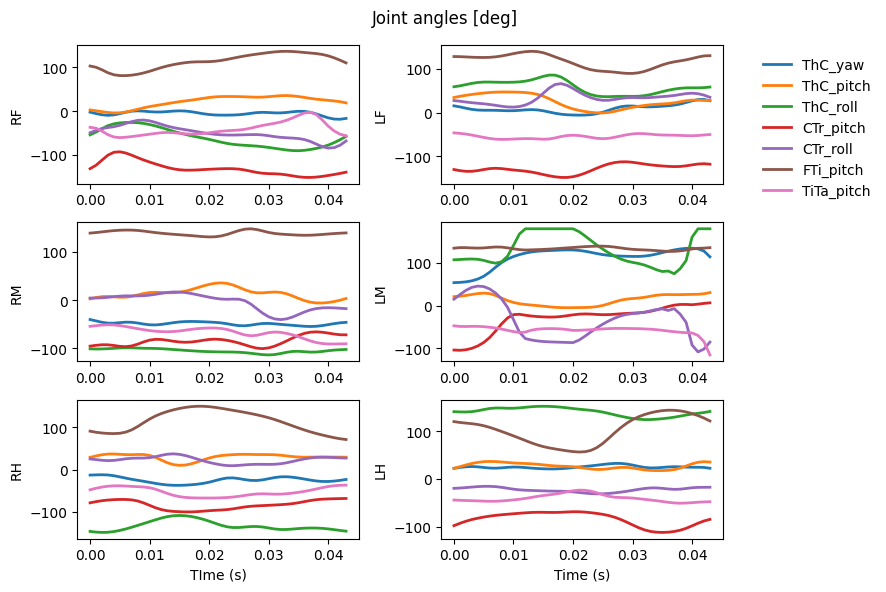

In [113]:
# Let's plot the joint angles for all six legs
plt.style.use('default')
fig, axs = plt.subplots(3,2, figsize=(9, 6), dpi=100)

time = np.arange(len(leg_joint_angles["Angle_LF_CTr_pitch"])) * aligned_pose_pp["meta"]["timestep"]

axs = axs.flatten()
for angle_name in ANGLES:
    for i, leg_name in enumerate(['RF', 'LF', 'RM', 'LM', 'RH', 'LH']):
        axs[i].plot(time,
            np.rad2deg(leg_joint_angles[f"Angle_{leg_name}_{angle_name}"]),
            label=angle_name,
            lw=2,
        )
        axs[i].set_ylabel(leg_name)


axs[-1].set_xlabel("Time (s)")
axs[-2].set_xlabel("TIme (s)")

axs[1].legend(bbox_to_anchor=(1.1, 1), frameon=False)

plt.suptitle('Joint angles [deg]')
plt.tight_layout()

# fig.savefig("../results/alljoints_follow_ikpy_left.png", bbox_inches="tight")
plt.show()

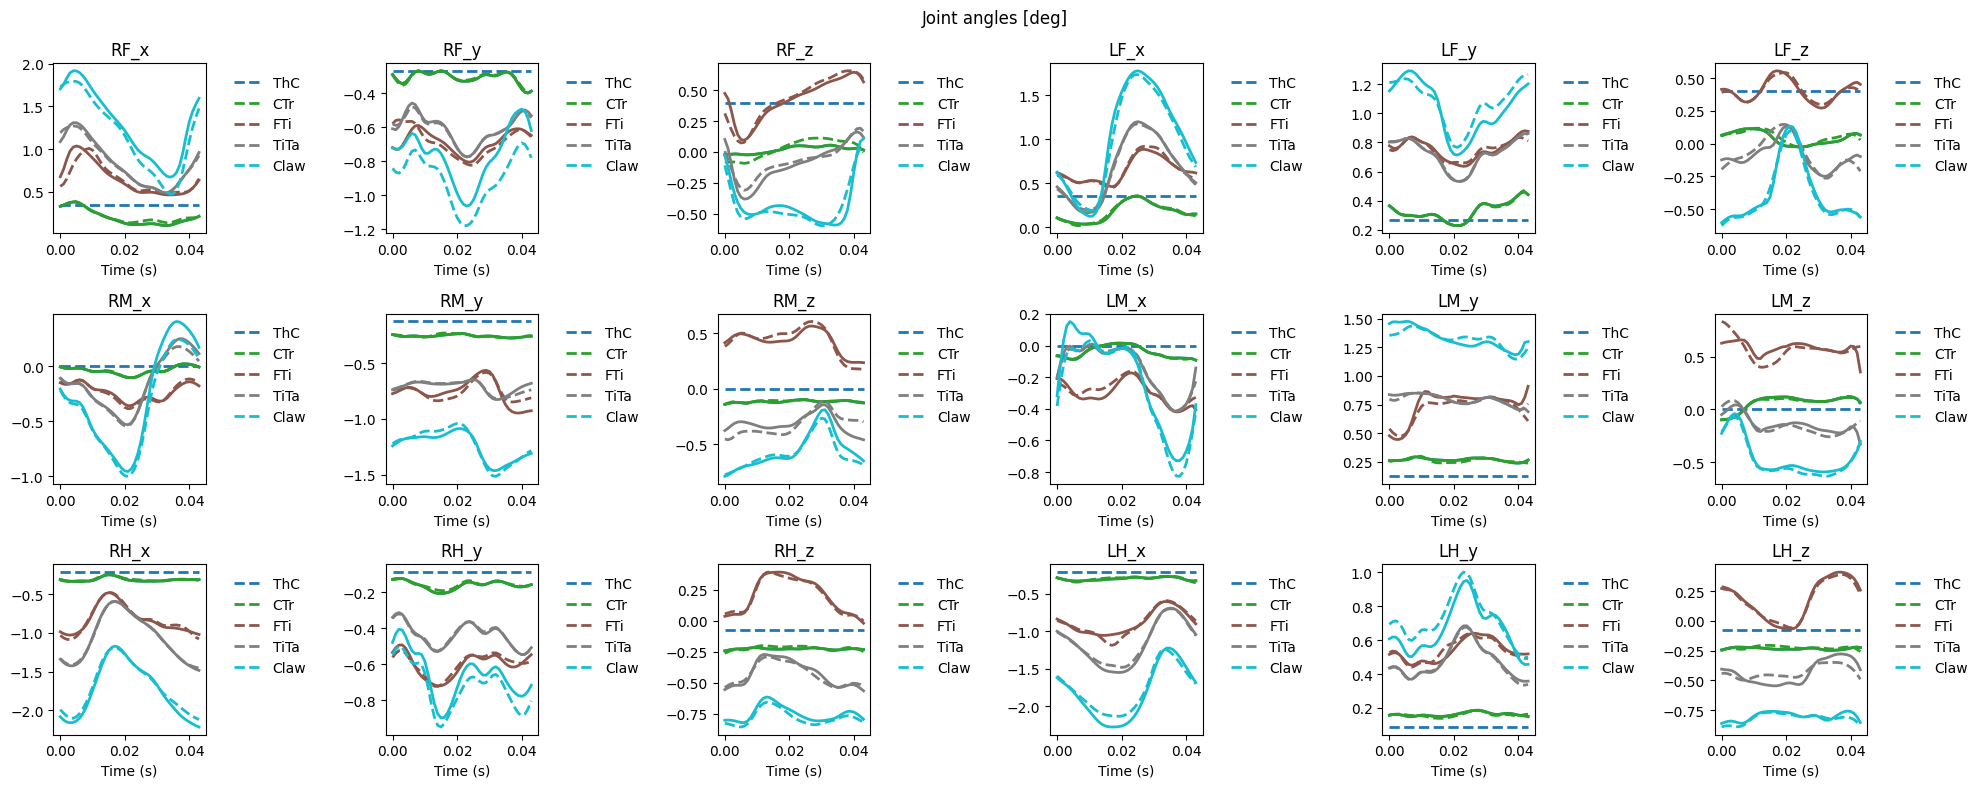

In [114]:
# plot forward kinematics and aligned pose
# Let's plot the joint angles for all six legs
plt.style.use('default')
fig, axs = plt.subplots(3,6, figsize=(20, 8), dpi=100)

time = np.arange(len(leg_joint_angles["Angle_LF_CTr_pitch"])) * aligned_pose_pp["meta"]["timestep"]
joints = ["ThC", "CTr", "FTi", "TiTa", "Claw"]

#get the colormap tab10
colors = plt.cm.tab10(np.linspace(0,1,len(joints)))

axs = axs.flatten()
for k, body_part in enumerate(joints):
    for i, leg_name in enumerate(['RF', 'LF', 'RM', 'LM', 'RH', 'LH']):
        for j in range(3):
            axs[i*3+j].plot(time,
                forward_kinematics[f"{leg_name}_leg"][:, -5:, :][:, k,j],
                lw=2,
                color=colors[k],
            )
            axs[i*3+j].plot(time,
                intpd_pose[f"{leg_name}_leg"][:, k,j],
                label=body_part,
                linestyle='--',
                lw=2,
                color=colors[k],
            )
            axs[i*3+j].set_title(f"{leg_name}_{['x','y','z'][j]}")
            axs[i*3+j].set_xlabel("Time (s)")
            if k == len(joints)-1:
                axs[i*3+j].legend(bbox_to_anchor=(1.1, 1), frameon=False)

plt.suptitle('Joint angles [deg]')
plt.tight_layout()

# fig.savefig("../results/alljoints_follow_ikpy_left.png", bbox_inches="tight")
plt.show()

In [115]:
forward_kinematics[f"{leg_name}_leg"].shape, intpd_pose[f"{leg_name}_leg"].shape

((44, 9, 3), (44, 5, 3))

## 3D visualization

See scripts for more information.

Making animation...
Animation is saved at /Users/stimpfli/Desktop/sleap_flytracker/labeled_slp/revision_new_step_PR_bestdata_fly001_trial001subset_video_4_start5751_end6001/output_3D_joints_alfie/ik_fk_comparison/fk_ik_elev_90_azim_0.mp4
Making animation...
Animation is saved at /Users/stimpfli/Desktop/sleap_flytracker/labeled_slp/revision_new_step_PR_bestdata_fly001_trial001subset_video_4_start5751_end6001/output_3D_joints_alfie/ik_fk_comparison/fk_ik_elev_90_azim_0.mp4
Making animation...
Animation is saved at /Users/stimpfli/Desktop/sleap_flytracker/labeled_slp/revision_new_step_PR_bestdata_fly001_trial001subset_video_4_start5751_end6001/output_3D_joints_alfie/ik_fk_comparison/fk_ik_elev_90_azim_0.mp4
Making animation...
Animation is saved at /Users/stimpfli/Desktop/sleap_flytracker/labeled_slp/revision_new_step_PR_bestdata_fly001_trial001subset_video_4_start5751_end6001/output_3D_joints_alfie/ik_fk_comparison/fk_ik_elev_90_azim_0.mp4


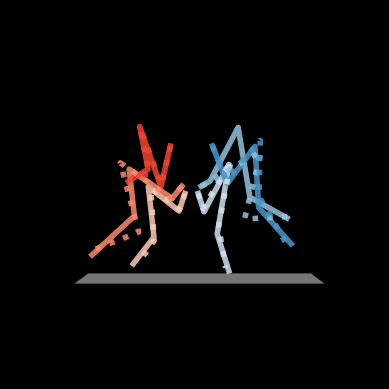

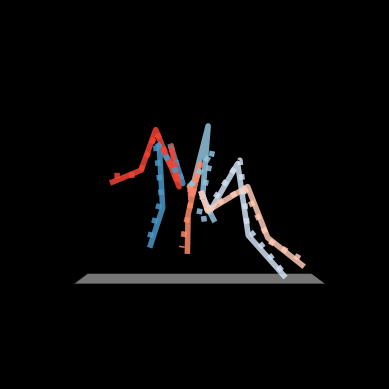

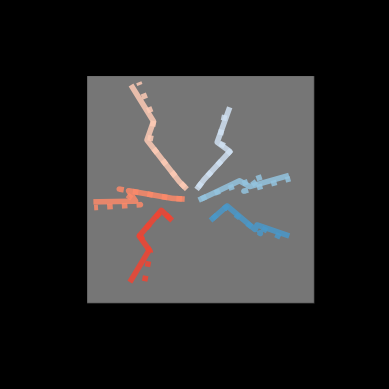

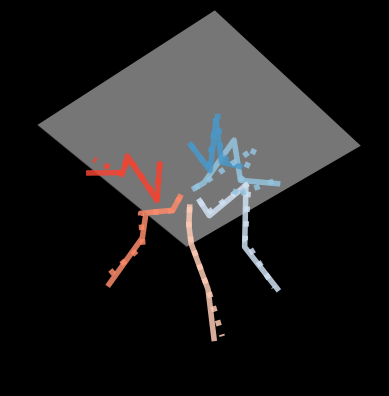

In [116]:
# Files saved automatically after the IK-FK process above.
pose3d = aligned_pose_path
forward_kinematics_path = DATA_PATH / "seq_ik_results/forward_kinematics.pkl"

with open(pose3d, "rb") as f:
    aligned_pose = pickle.load(f)
with open(forward_kinematics_path, "rb") as f:
    forward_kin = pickle.load(f)

points_aligned_all = np.concatenate(
    (
        intpd_pose["RF_leg"],
        intpd_pose["RM_leg"],
        intpd_pose["RH_leg"],
        intpd_pose["LF_leg"],
        intpd_pose["LM_leg"],
        intpd_pose["LH_leg"],
    ),
    axis=1,
)

points_fk = np.concatenate(
    (
        forward_kin["RF_leg"],
        forward_kin["RM_leg"],
        forward_kin["RH_leg"],
        forward_kin["LF_leg"],
        forward_kin["LM_leg"],
        forward_kin["LH_leg"],
    ),
    axis=1,
)

export_path_ik_fk_comparison = DATA_PATH / f"ik_fk_comparison/fk_ik_elev_{elev}_azim_{azim}.mp4"
export_path_ik_fk_comparison.parent.mkdir(exist_ok=True)

for azim, elev in [(0,0),(90,0),(0,90), (40, -45)]:
    animate_3d_points(
        points_aligned_all,
        KEY_POINTS_DICT,
        points3d_second=points_fk,
        key_points_second=KEY_POINTS_DICT2,
        export_path=export_path_ik_fk_comparison,
        frame_no=points_aligned_all.shape[0],
        elev=elev,
        azim=azim,
        fps=1,
    )


In [117]:
# If wanted, you can save each frame as a png file
base_fk_ik_export_path = DATA_PATH / 'fk_ik'
base_fk_ik_export_path.mkdir(exist_ok=True)
plt.style.use('default')
my_dpi = 150
for t in range(0, points_aligned_all.shape[0], 10):
    for azim, elev in [(0,0),(90,0),(0,90), (-45, 40)]:
        fig = plt.figure(figsize=(1024/my_dpi, 1024/my_dpi), dpi=my_dpi)
        ax3d = plt.axes(projection='3d')
        #ax3d = p3.Axes3D(fig)
        ax3d.view_init(azim=azim, elev=elev)

        ax3d.set_xlabel('x')
        ax3d.set_ylabel('y')
        ax3d.set_zlabel('z')

        plot_3d_points(
            ax3d,
            points_aligned_all,
            KEY_POINTS_DICT,
            label_prefix="Aligned pose ",
            t=t,
            fix_lim=True,
            lw=3
        )

        plot_3d_points(
            ax3d,
            points3d=points_fk,
            key_points=KEY_POINTS_DICT2,
            export_path=base_fk_ik_export_path/ f'azim_{azim}_elev_{elev}_{t//10}.png',
            label_prefix="Forward kinematics ",
            t=t,
            fix_lim=True,
            lw =3
        )
        plt.close()

In [118]:
"""import os

# use os and ffmpeg to make video from the png files
fps = 60
output_file = "/Users/stimpfli/Desktop/fly-tracker-setup/Candidacy_figures/videos/nice_forward_loc1_3dpos.mp4"
input_path = base_fk_ik_export_path
width, height = plt.imread(f"{input_path}/azim_40_elev_-45_0.png").shape[:2]
os.system(f"ffmpeg -r {fps} -y -f image2 -i {input_path}/azim_-45_elev_40_%d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {output_file}")"""

'import os\n\n# use os and ffmpeg to make video from the png files\nfps = 60\noutput_file = "/Users/stimpfli/Desktop/fly-tracker-setup/Candidacy_figures/videos/nice_forward_loc1_3dpos.mp4"\ninput_path = base_fk_ik_export_path\nwidth, height = plt.imread(f"{input_path}/azim_40_elev_-45_0.png").shape[:2]\nos.system(f"ffmpeg -r {fps} -y -f image2 -i {input_path}/azim_-45_elev_40_%d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {output_file}")'

In [119]:
for i in range(3):
    print(np.mean(forward_kin["RF_leg"][:, :, i], axis=0), np.std(forward_kin["RF_leg"][:, :, i], axis=0))

[0.35       0.35       0.35       0.35       0.20156672 0.20156672
 0.65592442 0.83505856 1.29389848] [2.22044605e-16 2.22044605e-16 2.22044605e-16 2.22044605e-16
 9.13947184e-02 9.13947184e-02 1.90600259e-01 2.67999605e-01
 4.06251841e-01]
[-0.27       -0.27       -0.27       -0.27       -0.30702319 -0.30702319
 -0.68576581 -0.60492492 -0.75997075] [2.77555756e-16 2.77555756e-16 2.77555756e-16 2.77555756e-16
 3.34405843e-02 3.34405843e-02 6.37463634e-02 8.65841265e-02
 1.58121514e-01]
[ 0.4         0.4         0.4         0.4         0.01779752  0.01779752
  0.42343221 -0.09429689 -0.42499252] [0.         0.         0.         0.         0.02766153 0.02766153
 0.16267002 0.15422483 0.17868885]


In [120]:
forward_kinematics["LM_leg"].shape, len(ANGLES)

((44, 9, 3), 7)

In [121]:
points_fk.shape

(44, 54, 3)

In [122]:
6*9

54